# Calculate and save footprints over entire period.

* ## Intersect with a map of the basin 

* ### Query given footprints and calculate contours

In [1]:
%matplotlib notebook
import sys
import os
import time
import numpy as np

from Klujn_2015_FootprinModel.calc_footprint_FFP_climatology_SkeeterEdits import FFP_climatology

import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon, shape

import rasterio
from rasterio import features
from rasterio.transform import from_origin
from matplotlib import pyplot as plt

from shapely.geometry import shape
from shapely.geometry import MultiPolygon

from geopandas import GeoDataFrame
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
from functools import partial
from multiprocessing import Pool
from rasterio.plot import show

import ProgressBar as prb

# Date Range & Paramters

In [2]:
FirstRun = False
DateRange=['2016-7-23 10:00:00','2016-7-23 20:30:00']
Query=['2016-7-23 10:00:00','2016-7-23 20:30:00','Test1',
      '2016-7-23 10:00:00','2016-7-23 20:30:00','Test2']
Axis = 40
rs = [50,75,90]
dx = 1
XY = [516097.33,7707931.12]
nx = 1000 
fp_params={'dx':dx,'nx':nx,'rs':rs}
west = XY[0]-(nx*dx)/2
north = XY[1]+(nx*dx)/2

RasterPath = 'C:/Illisarvik/Footprints/'
DataPath = 'C:/Illisarvik/FilteredData2018-04-16.csv'

## Read & filter the data, initialize the output raster

In [3]:
Data = pd.read_csv(DataPath)
Data = Data.set_index(pd.DatetimeIndex(Data.datetime))
Data['Run']=0
Data.loc[((np.isfinite(Data['Zo'])==True)&np.isfinite(Data['co2_flux'])==True)&(Data['u*']>.1)&
         (Data.index>DateRange[0])&(Data.index<DateRange[1])&
         ((Data['wind_dir']<Axis+180-30)|(Data['wind_dir']>Axis+180+30)),
         ['Run']]=1
Data=Data.reset_index(drop=True)
Dates = Data['datetime']
Run = Data.loc[Data['Run']==1].reset_index().drop(['index'],axis=1)
Runs = Run.shape[0]

Transform = from_origin(west,north,dx,dx)
with rasterio.open('temp.tif','w',driver='GTiff',width = nx+1, height = nx+1,count = 1,dtype=np.float64,
                   affine = Transform,crs = ({'init': 'EPSG:32608'})) as out:
    out_arr = out.read(1)
    params = out.profile
    


## Footprints

[                                                                                                   ]  0%

<IPython.core.display.Javascript object>


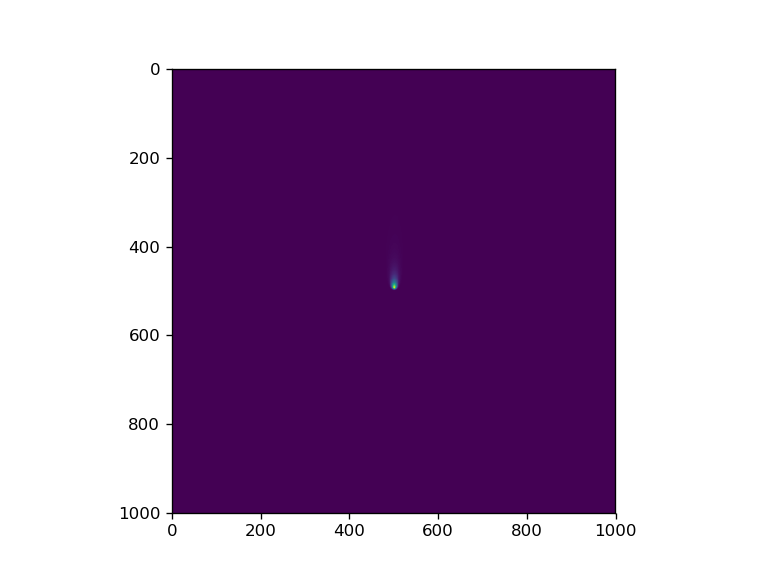

[||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||] 100.0%


In [4]:
Time = time.time()
def Run_Func(i,Run,fp_params):
    FP = FFP_climatology(zm=[Run['Zm'].iloc[i]],z0=[Run['Zo'].iloc[i]],h=[Run['PBLH'].iloc[i]],
                            ol=[Run['L'].iloc[i]],sigmav=[Run['v_var'].iloc[i]],ustar=[Run['u*'].iloc[i]],
                            wind_dir=[Run['wind_dir'].iloc[i]],
                             **fp_params,
                             )
    
    fpf = np.flipud(FP['fclim_2d'])*dx**2
    fpf/=fpf.sum()
    return(fpf)

Prog = prb.ProgressBar(Runs)

for i in range(Runs):
    Name = str(Run['datetime'].iloc[i]).replace(' ','_').replace('-','').replace(':','')
#     RunNames.append(Name)
    out = Run_Func(i,Run,fp_params)
    out /= out.sum()
    out_arr+=out
    with rasterio.open(RasterPath+'30min/'+str(Name)+'.tif','w',
                       driver='GTiff',width = nx, height = nx,count = 1,dtype=np.float64,
                       affine = Transform,crs = ({'init': 'EPSG:32608'})) as Writer:
        Writer.write(out,1)
#         show(Writer)
    Prog.Update(i)
out_arr /= i+1

with rasterio.open(RasterPath+'Climatology.tif','w',
                   driver='GTiff',width = nx, height = nx,count = 1,dtype=np.float64,
                   affine = Transform,crs = ({'init': 'EPSG:32608'})) as Writer:
    Writer.write(out_arr,1)
#     show(Writer)
    

## Generate contour

In [ ]:

Copy = out_arr+0.0
FlatCopy = np.sort(Copy.ravel())[::-1]

Cumsum = np.sort(Copy.ravel())[::-1].cumsum()

d = {}
d['contour'] = []
geometry = list()
for r in [.25,.50,.70,.80,.90]:
    
    pct = FlatCopy[np.where(Cumsum < r)]
    Mask = out_arr+0.0
    Mask[Mask>=pct[-1]] = 1
    Mask[Mask<pct[-1]] = np.nan
    multipart = 'No'
    for shp, val in features.shapes(Mask.astype('int16'), transform=Transform):
        if val == 1:
            d['contour'].append(r)
            Poly = shape(shp)
            Poly = Poly.buffer(dx, join_style=1).buffer(-dx, join_style=1)
            Poly = Poly.buffer(-dx, join_style=1).buffer(dx, join_style=1)
            if multipart == 'No':
                geometry.append(Poly)
            else:
                Multi = []
                for part in geometry[-1]:
                    Multi.append(part)
                Multi.append(Poly)
                geometry[-1]=MulitPolygon(Multi)
            mulitpart = 'Yes'
df = pd.DataFrame(data=d)

geo_df = GeoDataFrame(df,crs={'init': 'EPSG:32608'},geometry = geometry)
geo_df['area'] =  geo_df.area 
geo_df.to_file('Climatology.shp', driver = 'ESRI Shapefile')
geo_df.plot(facecolor='None',edgecolor='black')

print('Finished!')
print(time.time()-Time)

## Basin Map

<generator object <genexpr> at 0x00000261DE31D3B8>


<IPython.core.display.Javascript object>


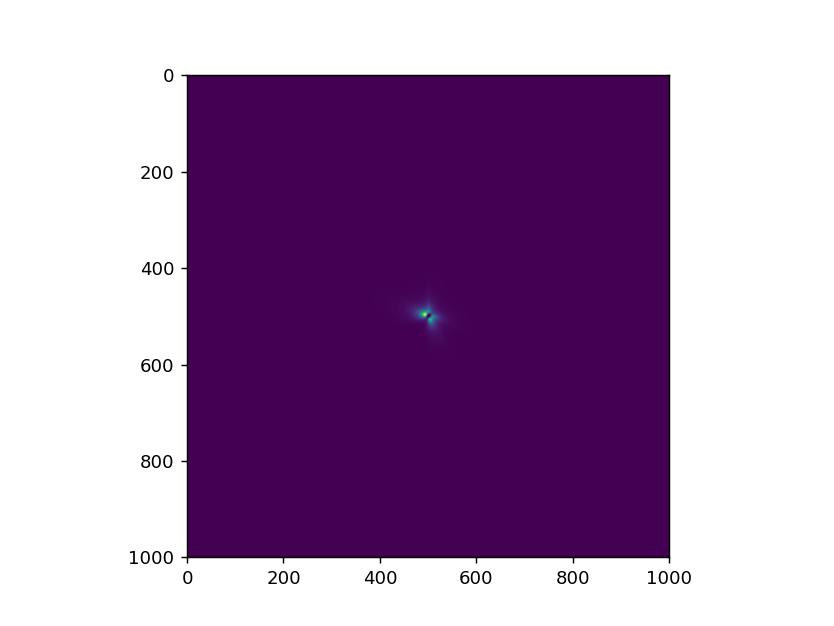

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 1001, 'height': 1001, 'count': 1, 'crs': CRS({}), 'transform': (515597.33, 1.0, 0.0, 7708431.12, 0.0, -1.0), 'affine': Affine(1.0, 0.0, 515597.33,
       0.0, -1.0, 7708431.12), 'tiled': False, 'interleave': 'band'}


In [5]:
Basin = gpd.read_file('C:/Illisarvik/Vegetation1.2.shp')
Basin['Area'] = Basin.area
Basin['Dkey'] = 1
BasinBounds = Basin.dissolve(by='Dkey').geometry[1]  

shapes = ((geom,value) for geom,value in zip(Basin['geometry'],Basin['Code']))
print(shapes)

west = XY[0]-(nx*dx)/2
north = XY[1]+(nx*dx)/2
Transform = from_origin(west,north,dx,dx)

plt.figure()

with rasterio.open('temp.tif','w',driver='GTiff',width = nx+1, height = nx+1,count = 1,dtype=np.float64,
                   affine = Transform,crs = ({'init': 'EPSG:32608'})) as out:
    out_arr = out.read(1)
    params = out.profile
    Image = features.rasterize(shapes=shapes,fill = 100,out = out_arr,transform = out.transform,default_value=0)

    plt.imshow(Image)
print(params)

## Intersect Function

In [ ]:
def Intersection():
    


In [ ]:
i= 2133
print(Run['Zm'].iloc[i],Run['Zo'].iloc[i],Run['PBLH'].iloc[i],
                            Run['L'].iloc[i],Run['v_var'].iloc[i],Run['u*'].iloc[i],
                        Run['wind_dir'].iloc[i])
i= 1
print(Run['Zm'].iloc[i],Run['Zo'].iloc[i],Run['PBLH'].iloc[i],
                            Run['L'].iloc[i],Run['v_var'].iloc[i],Run['u*'].iloc[i],
                        Run['wind_dir'].iloc[i])
A = Run_Func(i,Run,fp_params)
print(A)